# Reranker Evaluation

This notebook applies cross-encoder reranking to improve initial retrieval results.

Reranking is applied to:
- BM25 results (content and metadata)
- FAISS results (selected models)

Reranker: `cross-encoder/ms-marco-MiniLM-L-6-v2`

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

from src.data_loader import load_data, prepare_data, get_documents_by_field
from src.queries import get_all_queries
from src.reranker import Reranker, evaluate_reranking, save_reranking_results
from src.evaluation import print_query_results, calculate_overlap
from src.config import RESULTS_DIR, TOP_K

sns.set_style('whitegrid')
print("✓ Imports successful")

✓ Imports successful


## 1. Load Data and Previous Results

In [2]:
# Load data
df = load_data()
df = prepare_data(df)

# Get document lists
documents_content = get_documents_by_field(df, 'content')
documents_metadata = get_documents_by_field(df, 'metadata')

# Get queries
queries = get_all_queries()

print(f"Loaded {len(df)} documents and {len(queries)} queries")

Loading data from d:\Core\_Code D\LegalAI-model-eval\notebooks\..\data\acts_with_metadata.tsv...
Loaded 7067 records
Creating metadata field...
Metadata field created
Loaded 7067 documents and 10 queries


In [3]:
# Load previous retrieval results
def load_results(filename):
    """Load results from JSON file."""
    filepath = RESULTS_DIR / filename
    if filepath.exists():
        with open(filepath, 'r') as f:
            return json.load(f)
    else:
        print(f"Warning: {filename} not found")
        return None

# Load BM25 results
bm25_content = load_results("bm25_content_results.json")
bm25_metadata = load_results("bm25_metadata_results.json")

# Load FAISS results (Legal-BERT as example)
faiss_legalbert_content = load_results("faiss_legal-bert_content_results.json")
faiss_legalbert_metadata = load_results("faiss_legal-bert_metadata_results.json")

# Load FAISS results (BGE-Large as example)
faiss_bge_content = load_results("faiss_bge-large_content_results.json")
faiss_bge_metadata = load_results("faiss_bge-large_metadata_results.json")

print("\nLoaded results:")
for name, result in [
    ("BM25 Content", bm25_content),
    ("BM25 Metadata", bm25_metadata),
    ("FAISS Legal-BERT Content", faiss_legalbert_content),
    ("FAISS Legal-BERT Metadata", faiss_legalbert_metadata),
    ("FAISS BGE-Large Content", faiss_bge_content),
    ("FAISS BGE-Large Metadata", faiss_bge_metadata),
]:
    status = "✓" if result is not None else "✗"
    print(f"{status} {name}")


Loaded results:
✓ BM25 Content
✓ BM25 Metadata
✓ FAISS Legal-BERT Content
✓ FAISS Legal-BERT Metadata
✓ FAISS BGE-Large Content
✓ FAISS BGE-Large Metadata


## 2. Initialize Reranker

In [4]:
# Initialize the reranker (will be reused)
reranker = Reranker()
print("✓ Reranker initialized")

Loading reranker model: cross-encoder/ms-marco-MiniLM-L-6-v2


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--cross-encoder--ms-marco-MiniLM-L-6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Reranker loaded successfully
✓ Reranker initialized


## 3. Rerank BM25 Results

In [5]:
# Rerank BM25 content results
if bm25_content:
    print("Reranking BM25 Content results...")
    reranked_bm25_content = evaluate_reranking(
        documents=documents_content,
        queries=queries,
        initial_results=bm25_content['results'],
        retrieval_method="BM25",
        field_name="content",
        top_k=TOP_K
    )
    
    # Save results
    save_reranking_results(
        reranked_bm25_content, 
        RESULTS_DIR / "reranked_bm25_content.json"
    )
else:
    print("Skipping BM25 Content - results not found")

Reranking BM25 Content results...

RERANKING EVALUATION - BM25 - CONTENT

Loading reranker model: cross-encoder/ms-marco-MiniLM-L-6-v2
Reranker loaded successfully
Reranking query 1/10: What are the procedures for presidential elections...
Reranking query 2/10: What are the tax obligations and payment requireme...
Reranking query 3/10: What are the penalty provisions for bribery and un...
Reranking query 4/10: What is the process for filing appeals to the Boar...
Reranking query 5/10: What are the voting procedures and ballot requirem...
Reranking query 6/10: How are taxes assessed and collected, and what pow...
Reranking query 7/10: What are the establishment provisions and governan...
Reranking query 8/10: What are the import duty requirements and customs ...
Reranking query 9/10: What is the nomination process and requirements fo...
Reranking query 10/10: What are the powers and functions of the Commissio...

Results:
  Average reranking time: 0.6760 seconds
  Total queries: 10

Rer

In [6]:
# Rerank BM25 metadata results
if bm25_metadata:
    print("Reranking BM25 Metadata results...")
    reranked_bm25_metadata = evaluate_reranking(
        documents=documents_metadata,
        queries=queries,
        initial_results=bm25_metadata['results'],
        retrieval_method="BM25",
        field_name="metadata",
        top_k=TOP_K
    )
    
    # Save results
    save_reranking_results(
        reranked_bm25_metadata,
        RESULTS_DIR / "reranked_bm25_metadata.json"
    )
else:
    print("Skipping BM25 Metadata - results not found")

Reranking BM25 Metadata results...

RERANKING EVALUATION - BM25 - METADATA

Loading reranker model: cross-encoder/ms-marco-MiniLM-L-6-v2
Reranker loaded successfully
Reranking query 1/10: What are the procedures for presidential elections...
Reranking query 2/10: What are the tax obligations and payment requireme...
Reranking query 3/10: What are the penalty provisions for bribery and un...
Reranking query 4/10: What is the process for filing appeals to the Boar...
Reranking query 5/10: What are the voting procedures and ballot requirem...
Reranking query 6/10: How are taxes assessed and collected, and what pow...
Reranking query 7/10: What are the establishment provisions and governan...
Reranking query 8/10: What are the import duty requirements and customs ...
Reranking query 9/10: What is the nomination process and requirements fo...
Reranking query 10/10: What are the powers and functions of the Commissio...

Results:
  Average reranking time: 0.2563 seconds
  Total queries: 10

R

## 4. Rerank FAISS Results

In [7]:
# Rerank FAISS Legal-BERT content results
if faiss_legalbert_content:
    print("Reranking FAISS Legal-BERT Content results...")
    reranked_faiss_legalbert_content = evaluate_reranking(
        documents=documents_content,
        queries=queries,
        initial_results=faiss_legalbert_content['results'],
        retrieval_method="FAISS-LegalBERT",
        field_name="content",
        top_k=TOP_K
    )
    
    save_reranking_results(
        reranked_faiss_legalbert_content,
        RESULTS_DIR / "reranked_faiss_legalbert_content.json"
    )
else:
    print("Skipping FAISS Legal-BERT Content - results not found")

Reranking FAISS Legal-BERT Content results...

RERANKING EVALUATION - FAISS-LEGALBERT - CONTENT

Loading reranker model: cross-encoder/ms-marco-MiniLM-L-6-v2
Reranker loaded successfully
Reranking query 1/10: What are the procedures for presidential elections...
Reranking query 2/10: What are the tax obligations and payment requireme...
Reranking query 3/10: What are the penalty provisions for bribery and un...
Reranking query 4/10: What is the process for filing appeals to the Boar...
Reranking query 5/10: What are the voting procedures and ballot requirem...
Reranking query 6/10: How are taxes assessed and collected, and what pow...
Reranking query 7/10: What are the establishment provisions and governan...
Reranking query 8/10: What are the import duty requirements and customs ...
Reranking query 9/10: What is the nomination process and requirements fo...
Reranking query 10/10: What are the powers and functions of the Commissio...

Results:
  Average reranking time: 0.6727 seconds
 

In [8]:
# Rerank FAISS BGE-Large content results
if faiss_bge_content:
    print("Reranking FAISS BGE-Large Content results...")
    reranked_faiss_bge_content = evaluate_reranking(
        documents=documents_content,
        queries=queries,
        initial_results=faiss_bge_content['results'],
        retrieval_method="FAISS-BGE",
        field_name="content",
        top_k=TOP_K
    )
    
    save_reranking_results(
        reranked_faiss_bge_content,
        RESULTS_DIR / "reranked_faiss_bge_content.json"
    )
else:
    print("Skipping FAISS BGE-Large Content - results not found")

Reranking FAISS BGE-Large Content results...

RERANKING EVALUATION - FAISS-BGE - CONTENT

Loading reranker model: cross-encoder/ms-marco-MiniLM-L-6-v2
Reranker loaded successfully
Reranking query 1/10: What are the procedures for presidential elections...
Reranking query 2/10: What are the tax obligations and payment requireme...
Reranking query 3/10: What are the penalty provisions for bribery and un...
Reranking query 4/10: What is the process for filing appeals to the Boar...
Reranking query 5/10: What are the voting procedures and ballot requirem...
Reranking query 6/10: How are taxes assessed and collected, and what pow...
Reranking query 7/10: What are the establishment provisions and governan...
Reranking query 8/10: What are the import duty requirements and customs ...
Reranking query 9/10: What is the nomination process and requirements fo...
Reranking query 10/10: What are the powers and functions of the Commissio...

Results:
  Average reranking time: 0.6678 seconds
  Total 

## 5. Compare Before and After Reranking

In [9]:
# Compare BM25 before and after reranking for one query
def compare_before_after(query_id, initial_results, reranked_results, field='content'):
    """Compare initial and reranked results for a query."""
    query = queries[query_id - 1]
    query_idx = query_id - 1
    
    print(f"\n{'='*80}")
    print(f"QUERY {query_id}: {query['query']}")
    print(f"{'='*80}\n")
    
    # Initial results
    initial = initial_results['results'][query_idx]
    print("--- INITIAL RETRIEVAL ---")
    print(f"Top-3 indices: {initial['retrieved_indices'][:3]}")
    print(f"Top-3 scores: {[f'{s:.4f}' for s in initial['scores'][:3]]}\n")
    
    # Reranked results
    reranked = reranked_results['results'][query_idx]
    print("--- AFTER RERANKING ---")
    print(f"Top-3 indices: {reranked['reranked_indices'][:3]}")
    print(f"Top-3 scores: {[f'{s:.4f}' for s in reranked['reranked_scores'][:3]]}\n")
    
    # Calculate changes
    overlap = calculate_overlap(
        initial['retrieved_indices'][:TOP_K],
        reranked['reranked_indices'][:TOP_K]
    )
    
    print(f"Overlap: {overlap:.1%}")
    print(f"Reranking time: {reranked['reranking_time']:.4f}s")
    
    # Show if top result changed
    if initial['retrieved_indices'][0] != reranked['reranked_indices'][0]:
        print("\n⚠️ Top result changed after reranking!")
        print(f"  Before: Index {initial['retrieved_indices'][0]}")
        print(f"  After:  Index {reranked['reranked_indices'][0]}")

# Example: Compare BM25 content for query 1
if bm25_content and 'reranked_bm25_content' in locals():
    compare_before_after(1, bm25_content, reranked_bm25_content, 'content')


QUERY 1: What are the procedures for presidential elections when the office becomes vacant?

--- INITIAL RETRIEVAL ---
Top-3 indices: [0, 6689, 2308]
Top-3 scores: ['35.3770', '33.4456', '31.8071']

--- AFTER RERANKING ---
Top-3 indices: [0, 2308, 6689]
Top-3 scores: ['2.8057', '-6.9155', '-7.7773']

Overlap: 100.0%
Reranking time: 0.6713s



Reranking Impact (BM25 Content):
  Top-1 changed: 7/10 queries
  Queries with changed top-1: [2, 4, 5, 6, 7, 8, 10]


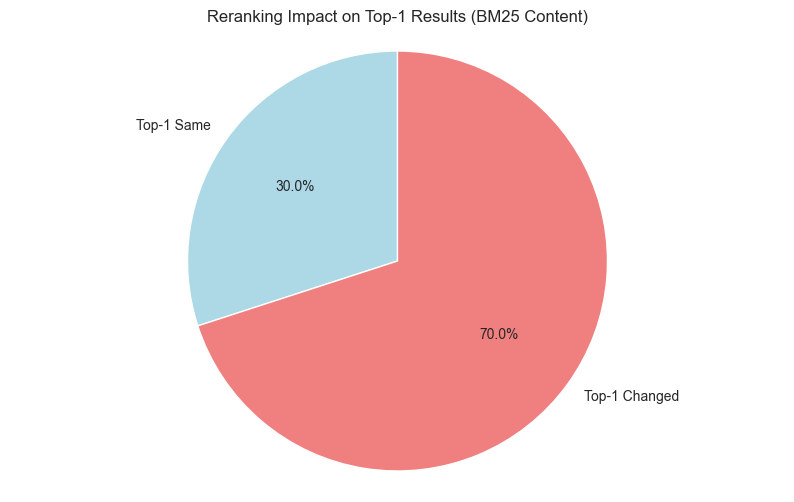

In [10]:
# Visualize reranking impact across all queries
if bm25_content and 'reranked_bm25_content' in locals():
    changes_count = 0
    top1_changes = []
    
    for i in range(len(queries)):
        initial = bm25_content['results'][i]['retrieved_indices']
        reranked = reranked_bm25_content['results'][i]['reranked_indices']
        
        # Check if top-1 changed
        if initial[0] != reranked[0]:
            changes_count += 1
            top1_changes.append(queries[i]['id'])
    
    print(f"\nReranking Impact (BM25 Content):")
    print(f"  Top-1 changed: {changes_count}/{len(queries)} queries")
    print(f"  Queries with changed top-1: {top1_changes}")
    
    # Visualize
    plt.figure(figsize=(10, 6))
    labels = ['Top-1 Same', 'Top-1 Changed']
    sizes = [len(queries) - changes_count, changes_count]
    colors = ['lightblue', 'lightcoral']
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Reranking Impact on Top-1 Results (BM25 Content)')
    plt.axis('equal')
    plt.show()

## 6. Analyze Reranking Performance


Reranking Performance:
          Method  Avg Reranking Time (s)
    BM25 Content                0.675950
   BM25 Metadata                0.256288
FAISS Legal-BERT                0.672666
       FAISS BGE                0.667818


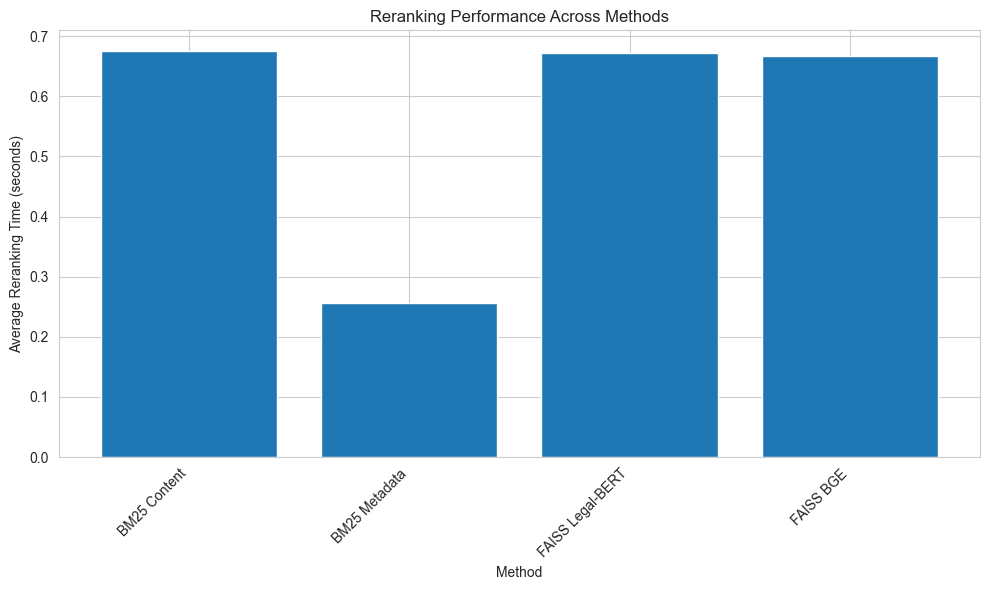

In [11]:
# Compare reranking times across different methods
reranking_times = []

reranked_results = [
    ('BM25 Content', reranked_bm25_content if 'reranked_bm25_content' in locals() else None),
    ('BM25 Metadata', reranked_bm25_metadata if 'reranked_bm25_metadata' in locals() else None),
    ('FAISS Legal-BERT', reranked_faiss_legalbert_content if 'reranked_faiss_legalbert_content' in locals() else None),
    ('FAISS BGE', reranked_faiss_bge_content if 'reranked_faiss_bge_content' in locals() else None),
]

for name, results in reranked_results:
    if results:
        reranking_times.append({
            'Method': name,
            'Avg Reranking Time (s)': results['avg_reranking_time']
        })

if reranking_times:
    reranking_df = pd.DataFrame(reranking_times)
    
    print("\nReranking Performance:")
    print(reranking_df.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.bar(reranking_df['Method'], reranking_df['Avg Reranking Time (s)'])
    plt.xlabel('Method')
    plt.ylabel('Average Reranking Time (seconds)')
    plt.title('Reranking Performance Across Methods')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 7. Detailed Query Analysis

In [12]:
# Interactive query explorer with reranking
def explore_reranked_query(query_id):
    """Explore a query showing initial and reranked results."""
    query = queries[query_id - 1]
    query_idx = query_id - 1
    
    print(f"\n{'='*80}")
    print(f"QUERY {query_id}: {query['query']}")
    print(f"Category: {query['category']}")
    print(f"{'='*80}\n")
    
    # BM25 Content - Before and After
    if bm25_content and 'reranked_bm25_content' in locals():
        print("\n--- BM25 CONTENT ---")
        initial = bm25_content['results'][query_idx]
        reranked = reranked_bm25_content['results'][query_idx]
        
        print("\nBefore Reranking (Top-3):")
        for i in range(min(3, len(initial['retrieved_indices']))):
            idx = initial['retrieved_indices'][i]
            score = initial['scores'][i]
            title = df.iloc[idx]['short_title']
            print(f"  {i+1}. [{score:.4f}] {title}")
        
        print("\nAfter Reranking (Top-3):")
        for i in range(min(3, len(reranked['reranked_indices']))):
            idx = reranked['reranked_indices'][i]
            score = reranked['reranked_scores'][i]
            title = df.iloc[idx]['short_title']
            marker = "★" if idx != initial['retrieved_indices'][i] else " "
            print(f" {marker}{i+1}. [{score:.4f}] {title}")

# Explore query 1
explore_reranked_query(1)


QUERY 1: What are the procedures for presidential elections when the office becomes vacant?
Category: Constitutional Law



In [13]:
# Explore another query
explore_reranked_query(2)


QUERY 2: What are the tax obligations and payment requirements for businesses with quarterly turnover?
Category: Tax Law



## 8. Overall Comparison: Initial vs Reranked

In [14]:
# Create comprehensive comparison
print("\nComplete Pipeline Comparison:")
print("="*80)

comparison_data = []

# BM25 Content
if bm25_content:
    comparison_data.append({
        'Method': 'BM25',
        'Field': 'Content',
        'Stage': 'Initial',
        'Avg Time (s)': bm25_content['avg_retrieval_time']
    })
    if 'reranked_bm25_content' in locals():
        comparison_data.append({
            'Method': 'BM25 + Reranker',
            'Field': 'Content',
            'Stage': 'Reranked',
            'Avg Time (s)': bm25_content['avg_retrieval_time'] + reranked_bm25_content['avg_reranking_time']
        })

# FAISS Legal-BERT Content
if faiss_legalbert_content:
    comparison_data.append({
        'Method': 'FAISS Legal-BERT',
        'Field': 'Content',
        'Stage': 'Initial',
        'Avg Time (s)': faiss_legalbert_content['avg_retrieval_time']
    })
    if 'reranked_faiss_legalbert_content' in locals():
        comparison_data.append({
            'Method': 'FAISS Legal-BERT + Reranker',
            'Field': 'Content',
            'Stage': 'Reranked',
            'Avg Time (s)': faiss_legalbert_content['avg_retrieval_time'] + reranked_faiss_legalbert_content['avg_reranking_time']
        })

if comparison_data:
    final_comparison = pd.DataFrame(comparison_data)
    print(final_comparison.to_string(index=False))
    
    # Save
    final_comparison.to_csv(RESULTS_DIR / "final_comparison_with_reranking.csv", index=False)
    print(f"\nSaved to: {RESULTS_DIR / 'final_comparison_with_reranking.csv'}")


Complete Pipeline Comparison:
                     Method   Field    Stage  Avg Time (s)
                       BM25 Content  Initial      0.040052
            BM25 + Reranker Content Reranked      0.716002
           FAISS Legal-BERT Content  Initial      0.079832
FAISS Legal-BERT + Reranker Content Reranked      0.752498

Saved to: d:\Core\_Code D\LegalAI-model-eval\notebooks\..\results\final_comparison_with_reranking.csv


## Summary

Reranking evaluation complete!

Key findings:
- Cross-encoder reranking applied to initial retrieval results
- Reranking can change the order of retrieved documents
- Trade-off: better ranking quality vs increased latency
- Two-stage retrieval (fast first-stage + reranker) is common in production

Benefits of reranking:
- ✓ More accurate relevance scoring
- ✓ Can correct mistakes from initial retrieval
- ✓ Cross-encoder captures query-document interactions

Considerations:
- ⚠️ Adds computational overhead
- ⚠️ Only improves ranking, doesn't add new documents
- ⚠️ Quality depends on initial retrieval recall

Next steps:
- Analyze which retrieval method benefits most from reranking
- Consider hybrid approaches (BM25 + FAISS + Reranker)
- Optimize for your latency/quality trade-off